<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/3_imageClassification_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
# dataset uploaded, it is already spilited by hand to train, test, valid, dev
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
!pip3 install bcolz  

In [87]:
%cd /content/drive/MyDrive/dogVsCat

/content/drive/MyDrive/dogVsCat


In [88]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [89]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [90]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [91]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [92]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [93]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [94]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [95]:
train_ds = datasets.ImageFolder(train_dir)

In [96]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [97]:
sz =224
batch_size = 16

tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
])

train_ds = datasets.ImageFolder(train_dir, transform=tfms)
valid_ds = datasets.ImageFolder(validation_dir, transform=tfms)

In [98]:
len(train_ds), len(valid_ds)

(2000, 1000)

In [99]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


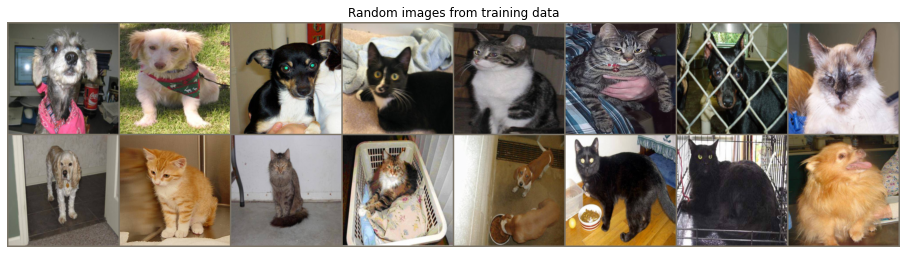

In [100]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

# Model:

In [101]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

In [102]:
model = SimpleCNN()

if use_gpu:
    model = model.cuda()

In [103]:
use_gpu

True

# loss Function

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# Train

In [105]:
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forwad pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses += [loss.data]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [ 1/ 5], Step [ 50/125], Loss: 3.4580
Epoch [ 1/ 5], Step [100/125], Loss: 0.9356
Epoch [ 2/ 5], Step [ 50/125], Loss: 0.6718
Epoch [ 2/ 5], Step [100/125], Loss: 0.7283
Epoch [ 3/ 5], Step [ 50/125], Loss: 0.7019
Epoch [ 3/ 5], Step [100/125], Loss: 0.5648
Epoch [ 4/ 5], Step [ 50/125], Loss: 0.7853
Epoch [ 4/ 5], Step [100/125], Loss: 0.5988
Epoch [ 5/ 5], Step [ 50/125], Loss: 0.7750
Epoch [ 5/ 5], Step [100/125], Loss: 0.4303


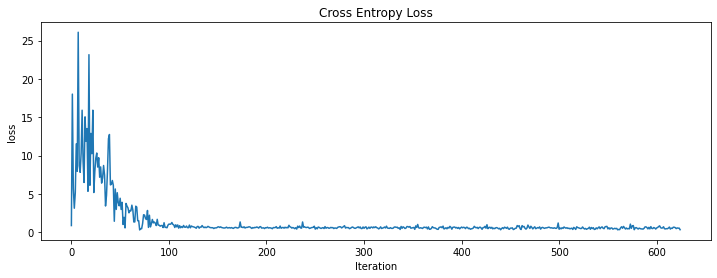

In [107]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

# Analayze results
## Accuracy on validation data

In [108]:
def evaluate_model(model, dataloader):
  model.eval()
  corrects = 0
  for inputs, targets in dataloader:
    inputs, targets = to_var(inputs, True), to_var(targets, True)
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    corrects += (preds == targets.data). sum()
  print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [109]:
evaluate_model(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 60.40


In [110]:
evaluate_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 75.10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


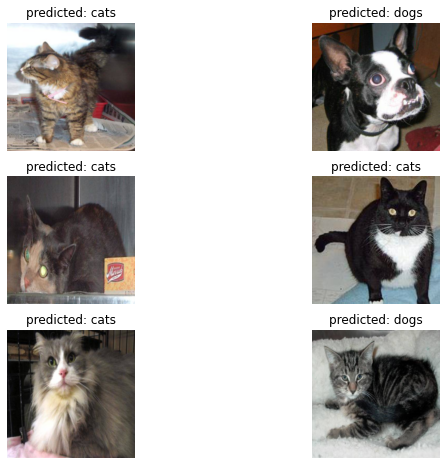

In [111]:
visualize_model(model, train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


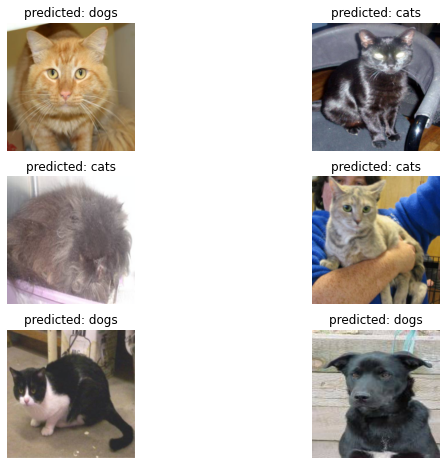

In [112]:
visualize_model(model, valid_dl)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0392189200>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0392189200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/

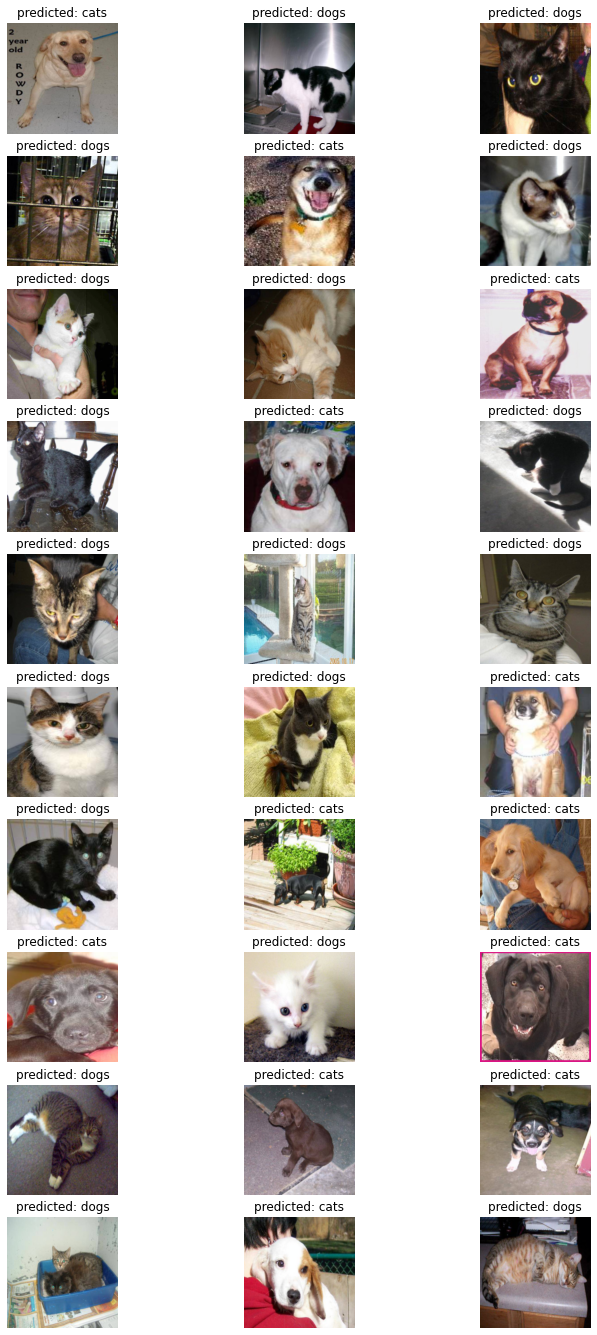

88 images out of 1000 were misclassified.


In [113]:
plot_errors(model, valid_dl)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 63/63 [00:05<00:00, 12.17it/s]


[[0.49 0.51]
 [0.28 0.72]]


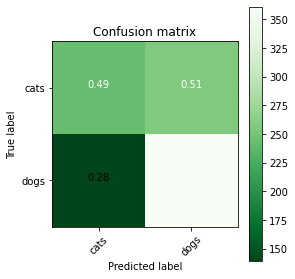

In [114]:
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4,4), cmap= "Greens_r")

# Overfit
- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

# Data Augmentation
- Scaling
- Rotation
- Flip horizontaly
- Random Crop
- Color jitter


In [117]:
# data augmentation and normalization for training
train_transforms = transforms.Compose([
                                       transforms.Resize((sz,sz)), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
                                      transforms.RandomRotation(20),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
                                      

# Just normalization for validation
valid_transforms = transforms.Compose([
                                       transforms.Resize((sz, sz)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
train_ds = datasets.ImageFolder(train_dir, train_transforms)
valid_ds = datasets.ImageFolder(train_dir, valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 2000
Valid size: 2000 (0.50)


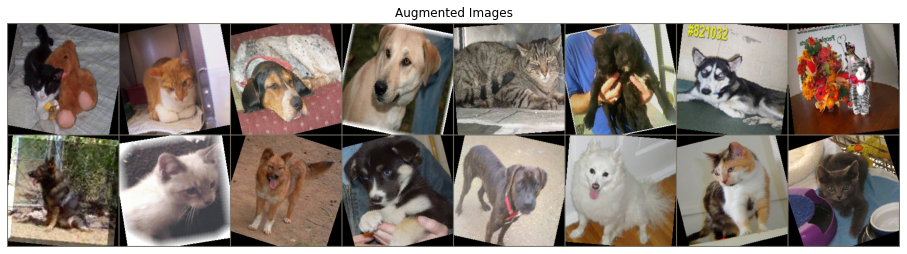

In [118]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

# create model

In [127]:
# create model
model = SimpleCNN()
if use_gpu:
    model = model.cuda()
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
  train Loss: 5.39989 Acc: 0.52150
  Step 1/125 | Loss: 0.64906

/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


  valid Loss: 0.68768 Acc: 0.54450

Epoch 2/5
----------
  train Loss: 0.68587 Acc: 0.55300
  valid Loss: 0.68346 Acc: 0.55300

Epoch 3/5
----------
  train Loss: 0.68818 Acc: 0.55350
  valid Loss: 0.68797 Acc: 0.54650

Epoch 4/5
----------
  train Loss: 0.68325 Acc: 0.56150
  valid Loss: 0.67384 Acc: 0.58150

Epoch 5/5
----------
  train Loss: 0.67332 Acc: 0.59200
  valid Loss: 0.65883 Acc: 0.62200

Training complete in 3m 4s
Best val Acc: 0.6220


# Transfer Learning

In [128]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=2)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [129]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=2)

Epoch 1/2
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  train Loss: 0.19063 Acc: 0.91550
  Step 0/125 | Loss: 0.05670

/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


  valid Loss: 0.02938 Acc: 0.98800

Epoch 2/2
----------
  train Loss: 0.06243 Acc: 0.97700
  valid Loss: 0.00853 Acc: 0.99850

Training complete in 1m 58s
Best val Acc: 0.9985


In [130]:
evaluate_model(model, valid_dl)

/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


accuracy: 99.85


/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)


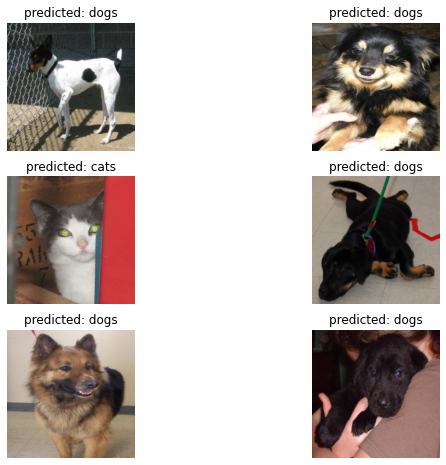

In [131]:
visualize_model(model, valid_dl, num_images=6)

  0%|          | 0/125 [00:00<?, ?it/s]/content/drive/MyDrive/dogVsCat/utils.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(x, volatile=volatile)
100%|██████████| 125/125 [00:15<00:00,  8.11it/s]


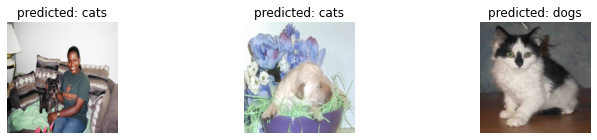

3 images out of 2000 were misclassified.


In [132]:
plot_errors(model, valid_dl)